#Semestralní práce z předmětu
## 4IZ175 Neuronové sítě a deep learning
### Autoři: Kutukov Nikolay, Iana Minibaeva

---



Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import resnet50, MobileNetV2
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

## Čast 1: obraz

### Popis Datasetu

Soubor dat o domácích mazlíčcích Oxford-IIIT je soubor dat o 37 kategoriích obrázků domácích mazlíčků se zhruba 200 obrázky pro každou třídu. Obrázky mají velké rozdíly v měřítku, póze a osvětlení. Ke všem obrázkům je přiřazena základní pravdivá anotace plemene.
- **Total Samples:** 7 349 obrázků
- **Number of Classes:** 37 plemen domácích zvířat
- **Class Distribution:** Zhruba 200 snímků na plemeno
- **Missing Values:** Žádné
- **Source:** [Oxford IIIT Pet Dataset](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet)
- **Data Splits:**
  - **Training Set:** 3680
  - **Validation Set:** 1669
  - **Testing Set:** 2000


In [2]:
builder = tfds.builder("oxford_iiit_pet")
dataset_info = builder.info
print(dataset_info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpd8hy_g7qtfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

### Popis Řešené Úlohy


Úkolem je příprava architektury modelu pro klasifikaci obrazů zvířat, trénink a hodnocení výkonu modelu probíhá na datech z datasetu oxford_iiit_pet.

### Předzpracování Datasetu

In [3]:
train_ds, test_ds, val_ds = tfds.load("oxford_iiit_pet", split=['train', 'test[:2000]', 'test[2000:]'], as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteEILA4H/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteEILA4H/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 224
batch_size = 32
num_classes = 37

def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  #image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
  image = (image / 255.0)
  label = tf.one_hot(label, num_classes)
  return image, label

train_dataset = (
    train_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

validation_dataset = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_dataset = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

### Modelování

#### CNN(3/4 vrstvy) - 30 sekund/1 minuta GPU

Convolutional Neural Networks (CNN) jsou ideální pro úlohy související s obrazem, jako je klasifikace plemen domácích zvířat v datové sadě Oxford IIIT Pet, protože mají specifické výhody v architektuře modelu:

1. **Detekce vlastností**: CNN skvěle rozpoznává klíčové znaky, jako jsou tvary uší, barevné vzory a textury domácích zvířat, které jsou nezbytné pro rozlišení plemen.

2. **Hierarchické učení**: CNN zpracovává obrazy ve vrstvách, počínaje jednoduchými rysy, jako jsou hrany v počátečních vrstvách, až po složité aspekty, jako jsou celé obličejové komponenty v hlubších vrstvách. Tato metoda dobře odpovídá tomu, jak jsou obrazy strukturovány, díky čemuž jsou CNN velmi efektivní pro analýzu obrazů.

3. **Minimální předzpracování**: CNN si vystačí s menším množstvím předzpracování, učí se přímo ze vstupních obrazových dat a automaticky určují nejrelevantnější rysy pro danou úlohu.

4. **Translation Invariance**: CNN dokáže rozpoznat naučené rysy kdekoli v obraze, což je cenná vlastnost pro tuto úlohu, kde domácí zvířata nemusí být vždy umístěna nebo orientována centrálně.

In [5]:
cnn_model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [6]:
earlystopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta = 0.002, restore_best_weights=True)

history = cnn_model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=[earlystopping_callback])

test_loss, test_accuracy = cnn_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/30
115/115 [==============================] - 8s 26ms/step - loss: 3.6289 - accuracy: 0.0296 - val_loss: 3.5892 - val_accuracy: 0.0371
Epoch 2/30
115/115 [==============================] - 3s 22ms/step - loss: 3.4426 - accuracy: 0.0802 - val_loss: 3.3843 - val_accuracy: 0.0941
Epoch 3/30
115/115 [==============================] - 2s 21ms/step - loss: 2.8590 - accuracy: 0.2228 - val_loss: 3.5418 - val_accuracy: 0.1055
Epoch 4/30
115/115 [==============================] - 2s 21ms/step - loss: 2.0056 - accuracy: 0.4489 - val_loss: 5.5956 - val_accuracy: 0.1001
Epoch 5/30
115/115 [==============================] - 2s 21ms/step - loss: 1.3150 - accuracy: 0.6353 - val_loss: 7.0659 - val_accuracy: 0.0863
Epoch 6/30
115/115 [==============================] - 3s 23ms/step - loss: 0.8346 - accuracy: 0.7832 - val_loss: 8.1300 - val_accuracy: 0.0911
Epoch 7/30
63/63 [==============================] - 1s 16ms/step - loss: 3.4021 - accuracy: 0.0870
Test Loss: 3.402122974395752
Test Accuracy:

In [7]:
from tensorflow.keras import layers, models

cnn_model_more_layers = models.Sequential([
    # Random Transformations to prevent overfitting
    #layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.RandomZoom(0.2),

    # First convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Fourth convolutional layer
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten the output
    layers.Flatten(),

    # Fully connected layer
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(num_classes, activation='softmax')
])

# Model Compilation
cnn_model_more_layers.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model_more_layers.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                      

In [8]:
earlystopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta = 0.002, restore_best_weights=True)

history_cnn = cnn_model_more_layers.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=[earlystopping_callback])

test_loss, test_accuracy = cnn_model_more_layers.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/30
115/115 [==============================] - 11s 36ms/step - loss: 4.1774 - accuracy: 0.0671 - val_loss: 15.7952 - val_accuracy: 0.0264
Epoch 2/30
115/115 [==============================] - 4s 34ms/step - loss: 3.9420 - accuracy: 0.0940 - val_loss: 6.3525 - val_accuracy: 0.0383
Epoch 3/30
115/115 [==============================] - 4s 35ms/step - loss: 3.4376 - accuracy: 0.1516 - val_loss: 5.0497 - val_accuracy: 0.0449
Epoch 4/30
115/115 [==============================] - 4s 34ms/step - loss: 3.3172 - accuracy: 0.1606 - val_loss: 4.2971 - val_accuracy: 0.0641
Epoch 5/30
115/115 [==============================] - 4s 35ms/step - loss: 3.0214 - accuracy: 0.2092 - val_loss: 3.8407 - val_accuracy: 0.1072
Epoch 6/30
115/115 [==============================] - 4s 36ms/step - loss: 2.8159 - accuracy: 0.2408 - val_loss: 3.2664 - val_accuracy: 0.1684
Epoch 7/30
115/115 [==============================] - 4s 33ms/step - loss: 2.6140 - accuracy: 0.2723 - val_loss: 3.6152 - val_accuracy: 0.14

#### MLP

In [9]:
mlp_model = models.Sequential([
    layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(37, activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

mlp_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 512)               77070848  
                                                                 
 batch_normalization_5 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_6 (Bat  (None, 256)               1024      
 chNormalization)                                     

In [10]:
earlystopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.002, restore_best_weights=True)

history_mlp = mlp_model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=[earlystopping_callback])

test_loss, test_accuracy = mlp_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/30
115/115 [==============================] - 6s 27ms/step - loss: 4.5310 - accuracy: 0.0386 - val_loss: 4.2924 - val_accuracy: 0.0395
Epoch 2/30
115/115 [==============================] - 3s 25ms/step - loss: 4.1370 - accuracy: 0.0437 - val_loss: 3.5849 - val_accuracy: 0.0647
Epoch 3/30
115/115 [==============================] - 3s 23ms/step - loss: 3.9090 - accuracy: 0.0565 - val_loss: 3.5215 - val_accuracy: 0.0647
Epoch 4/30
115/115 [==============================] - 3s 23ms/step - loss: 3.7910 - accuracy: 0.0609 - val_loss: 3.4460 - val_accuracy: 0.0749
Epoch 5/30
115/115 [==============================] - 2s 21ms/step - loss: 3.6849 - accuracy: 0.0554 - val_loss: 3.4532 - val_accuracy: 0.0785
Epoch 6/30
115/115 [==============================] - 3s 26ms/step - loss: 3.6183 - accuracy: 0.0592 - val_loss: 3.4375 - val_accuracy: 0.0749
Epoch 7/30
115/115 [==============================] - 3s 28ms/step - loss: 3.5492 - accuracy: 0.0685 - val_loss: 3.4340 - val_accuracy: 0.0791

#### Pretrained model

In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False
#base_model.trainable = True
# Let's fine-tune the top 10 layers
for layer in base_model.layers[:-5]:
    layer.trainable = True

pretrained_model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dense(37, activation='softmax')
])

pretrained_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

pretrained_model.summary()

9406464/9406464 [==============================] - 2s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_8 (Dense)             (None, 128)               163968    
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 37)                2405      
                                                         

In [12]:
earlystopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.002, restore_best_weights=True)
history_pretrain = pretrained_model.fit(train_dataset, epochs=20, validation_data=validation_dataset, callbacks=[earlystopping_callback])

test_loss, test_accuracy = pretrained_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/20
115/115 [==============================] - 8s 36ms/step - loss: 4.0619 - accuracy: 0.5505 - val_loss: 2.5576 - val_accuracy: 0.7579
Epoch 2/20
115/115 [==============================] - 3s 27ms/step - loss: 2.0054 - accuracy: 0.8462 - val_loss: 1.9027 - val_accuracy: 0.7891
Epoch 3/20
115/115 [==============================] - 3s 27ms/step - loss: 1.4733 - accuracy: 0.9000 - val_loss: 1.5494 - val_accuracy: 0.8107
Epoch 4/20
115/115 [==============================] - 3s 27ms/step - loss: 1.2062 - accuracy: 0.9239 - val_loss: 1.3597 - val_accuracy: 0.8262
Epoch 5/20
115/115 [==============================] - 3s 27ms/step - loss: 1.0540 - accuracy: 0.9389 - val_loss: 1.2502 - val_accuracy: 0.8424
Epoch 6/20
115/115 [==============================] - 3s 27ms/step - loss: 0.9633 - accuracy: 0.9473 - val_loss: 1.1883 - val_accuracy: 0.8472
Epoch 7/20
115/115 [==============================] - 3s 27ms/step - loss: 0.9038 - accuracy: 0.9503 - val_loss: 1.1426 - val_accuracy: 0.8466

### Evaluace Modelů

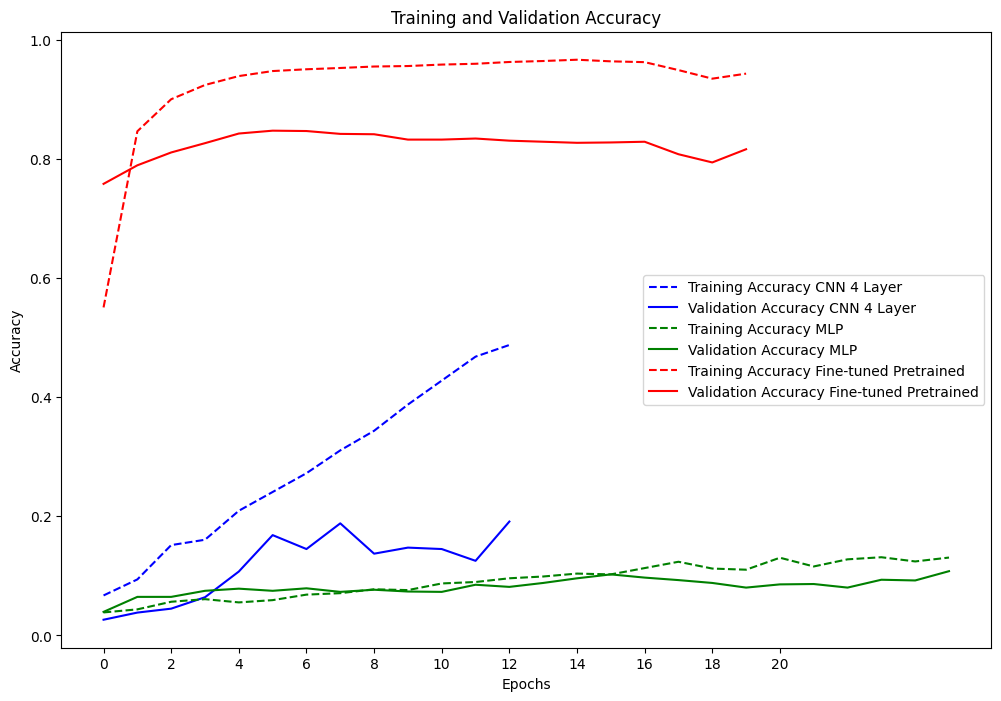

In [13]:
import matplotlib.pyplot as plt

# Function to plot accuracy
def plot_accuracy(history, label, color):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(accuracy))

    plt.plot(epochs, accuracy, '--', label=f'Training Accuracy {label}', color=color)
    plt.plot(epochs, val_accuracy, label=f'Validation Accuracy {label}', color=color)

plt.figure(figsize=(12, 8))

plot_accuracy(history_cnn, 'CNN 4 Layer', 'blue')
plot_accuracy(history_mlp, 'MLP', 'green')
plot_accuracy(history_pretrain, 'Fine-tuned Pretrained', 'red')
# Add titles and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(0,21,2))
# Show the plot
plt.show()

## Čast 2: text

### Popis Datasetu

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
dataframe = pd.read_csv('drive/MyDrive/amazon_reviews_us_Software_v1_00.tsv', sep='\t', on_bad_lines='skip')
subset_df = dataframe.sample(n=80000, random_state=42)
subset_df = subset_df.dropna(subset=['review_body'])

### Popis Řešené Úlohy

### Předzpracování Datasetu

In [16]:
import tensorflow as tf
# mapování pětihvězdičkového hodnocení na negativní, neutrální a pozitivní recenze
def add_binning(x):
  if x in [1,2]:
    return 0
  elif x == 3:
    return 1
  elif x in [4,5]:
    return 2
  else:
    return -1
# převod tensoru fo numpy.array
def to_numpy(y_true):
  arr = []
  for element in y_true.as_numpy_iterator():
    arr.append(element)
  return np.concatenate(arr)

X, y = subset_df['review_body'], subset_df['star_rating']
X, y = X, y.apply(add_binning)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 10000

# Prepare the datasets
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [17]:
from tensorflow.keras.layers import TextVectorization
max_len = 200
text_vectorization = TextVectorization(
    ngrams=1,
    max_tokens=5000,
    output_mode="int",
    output_sequence_length=max_len
)
text_vectorization.adapt(train_dataset.map(lambda x, y: x))

In [18]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=AUTOTUNE)

validation_ds = val_dataset.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=AUTOTUNE)

test_ds = test_dataset.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=AUTOTUNE)

### Modelování

#### MLP - 1 minuta

In [19]:
from tensorflow.keras.layers import Embedding, GRU, Dense, GlobalAveragePooling1D, SimpleRNN, Flatten, Dropout
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
import keras
# Parameters
max_tokens = 10000  # Same as the max_tokens used in TextVectorization
embedding_dim = 64
num_classes = 3

# Build the model
mlp_model_2 = Sequential([
    layers.Embedding(max_tokens, embedding_dim, input_length=max_len),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

# Compile the model
mlp_model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              metrics=['accuracy'])

# Print the model summary
mlp_model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0         
                                                                 
 dense_11 (Dense)            (None, 64)                819264    
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 3)                

In [20]:
earlystopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta = 0.002, restore_best_weights=True)

history_mlp_2 = mlp_model_2.fit(train_ds, epochs=15, validation_data=validation_ds, callbacks=[earlystopping_callback])

# Evaluate the model on the test set
test_loss, test_accuracy = mlp_model_2.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/15
2025/2025 [==============================] - 67s 32ms/step - loss: 0.7952 - accuracy: 0.7631 - val_loss: 0.6802 - val_accuracy: 0.8044
Epoch 2/15
2025/2025 [==============================] - 13s 6ms/step - loss: 0.6861 - accuracy: 0.8049 - val_loss: 0.6796 - val_accuracy: 0.8072
Epoch 3/15
2025/2025 [==============================] - 11s 6ms/step - loss: 0.6759 - accuracy: 0.8172 - val_loss: 0.7379 - val_accuracy: 0.7904
Epoch 4/15
2025/2025 [==============================] - 9s 4ms/step - loss: 0.6743 - accuracy: 0.8236 - val_loss: 0.7261 - val_accuracy: 0.8082
Epoch 5/15
2025/2025 [==============================] - 9s 4ms/step - loss: 0.6755 - accuracy: 0.8353 - val_loss: 0.7730 - val_accuracy: 0.8036
Epoch 6/15
250/250 [==============================] - 1s 2ms/step - loss: 0.6782 - accuracy: 0.8015
Test Loss: 0.6782498955726624
Test Accuracy: 0.8015000224113464


In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# def to_numpy(y_true):
#   arr = []
#   for element in y_true.as_numpy_iterator():
#     arr.append(element)
#   return np.concatenate(arr)

# Generate predictions
y_pred = mlp_model_2.predict(test_ds.map(lambda x, y: x))
y_pred_classes = y_pred.argmax(axis=1)
y_true = test_ds.map(lambda x, y: y)
y_true = to_numpy(y_true)

250/250 [==============================] - 0s 1ms/step


#### GRU

In [23]:

from keras.regularizers import l2
import keras
# Parameters
max_tokens = 10000  # Same as the max_tokens used in TextVectorization
embedding_dim = 64
num_classes = 3  # For the five-star rating system

# Build the model
model_gru = Sequential([
    layers.Embedding(max_tokens, embedding_dim, input_length=max_len),
    layers.GRU(128, return_sequences=False),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

# Compile the model
model_gru.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 64)           640000    
                                                                 
 gru_1 (GRU)                 (None, 128)               74496     
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 3)                 99        
                                                                 
Total params: 724931 (2.77 MB)
Trainable params: 724931 (2.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
earlystopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.002, restore_best_weights=True)

history_gru = model_gru.fit(train_ds, epochs=20, validation_data=validation_ds, callbacks=[earlystopping_callback])

# Evaluate the model on the test set
test_loss, test_accuracy = model_gru.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/20
2025/2025 [==============================] - 57s 27ms/step - loss: 0.7287 - accuracy: 0.7378 - val_loss: 0.5277 - val_accuracy: 0.8147
Epoch 2/20
2025/2025 [==============================] - 24s 12ms/step - loss: 0.4869 - accuracy: 0.8291 - val_loss: 0.4742 - val_accuracy: 0.8346
Epoch 3/20
2025/2025 [==============================] - 23s 11ms/step - loss: 0.4395 - accuracy: 0.8452 - val_loss: 0.4656 - val_accuracy: 0.8347
Epoch 4/20
2025/2025 [==============================] - 20s 10ms/step - loss: 0.4060 - accuracy: 0.8546 - val_loss: 0.4770 - val_accuracy: 0.8329
Epoch 5/20
2025/2025 [==============================] - 21s 10ms/step - loss: 0.3746 - accuracy: 0.8631 - val_loss: 0.4733 - val_accuracy: 0.8308
Epoch 6/20
2025/2025 [==============================] - 22s 11ms/step - loss: 0.3448 - accuracy: 0.8738 - val_loss: 0.5023 - val_accuracy: 0.8289
Epoch 7/20
2025/2025 [==============================] - 21s 10ms/step - loss: 0.3153 - accuracy: 0.8846 - val_loss: 0.5165 -

### Evaluace Modelů

250/250 [==============================] - 0s 1ms/step


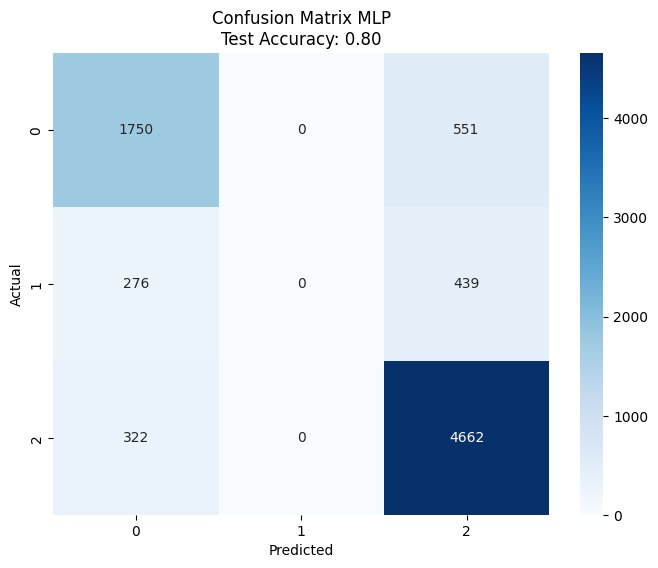

In [25]:
y_pred = mlp_model_2.predict(test_ds.map(lambda x, y: x))
y_pred_classes = y_pred.argmax(axis=1)
y_true = test_ds.map(lambda x, y: y)
y_true = to_numpy(y_true)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
test_accuracy = accuracy_score(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix MLP\nTest Accuracy: {test_accuracy:.2f}')
plt.show()

250/250 [==============================] - 1s 4ms/step


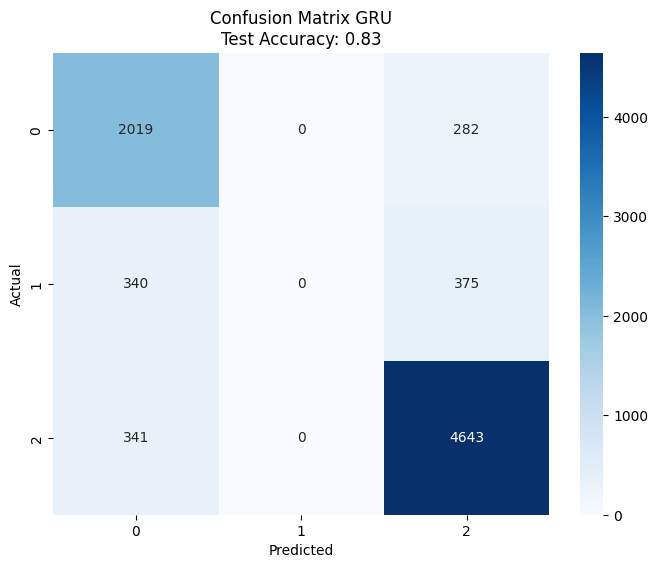

In [26]:
y_pred = model_gru.predict(test_ds.map(lambda x, y: x))
y_pred_classes = y_pred.argmax(axis=1)
y_true = test_ds.map(lambda x, y: y)
y_true = to_numpy(y_true)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
test_accuracy = accuracy_score(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix GRU\nTest Accuracy: {test_accuracy:.2f}')
plt.show()

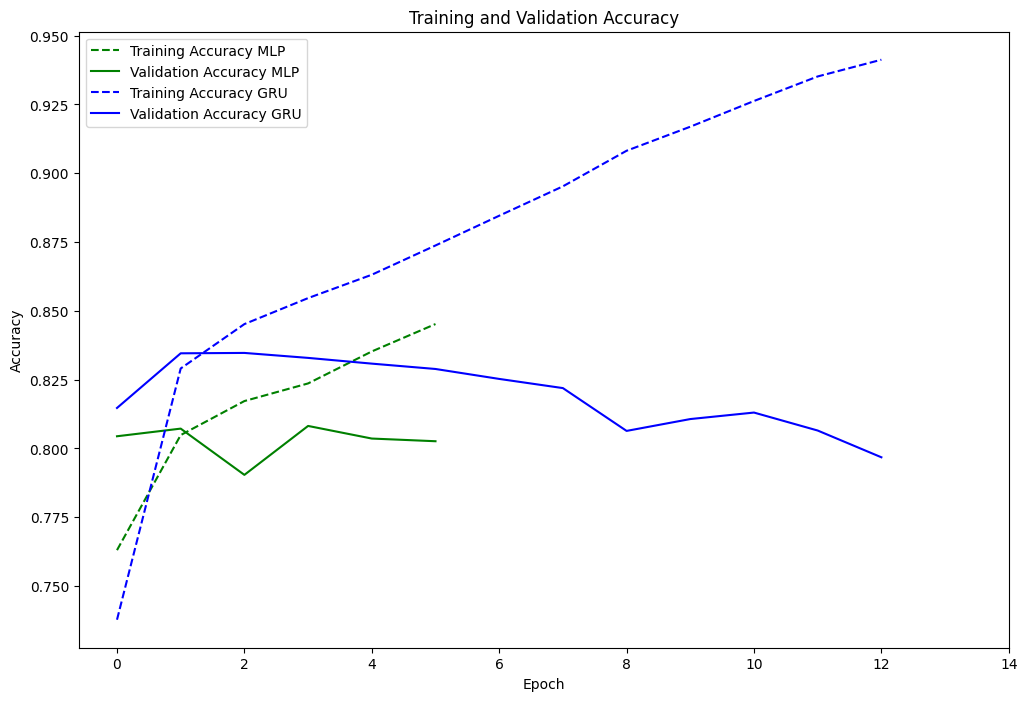

In [27]:
import matplotlib.pyplot as plt

def plot_accuracy(history, label, color):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(accuracy))

    plt.plot(epochs, accuracy, '--', label=f'Training Accuracy {label}', color=color)
    plt.plot(epochs, val_accuracy, label=f'Validation Accuracy {label}', color=color)

plt.figure(figsize=(12, 8))

plot_accuracy(history_mlp_2, 'MLP', 'green')
plot_accuracy(history_gru, 'GRU', 'blue')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(0,16,2))

plt.show()

In [ ]:
GRU dosahuje nejlepších výsledků

Konfigurace - Google Colab GPU A100